# 初期化

- S&P500と有名な高配当投資信託の相関を計算する
    - 単純相関は，色々分析されているが，トレンドと変動を分離して変動の相関を取りたい

In [1]:
import toml
import pandas as pd
import datetime
import copy
import numpy as np

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns
import matplotlib.pyplot as plt

from pptx import Presentation
from pptx.util import Cm, Pt, Inches  # 単位変換機能
from pptx.dml.color import RGBColor   # 色指定用

In [2]:
labels = [  'VOO'  # S&P500 連動 ETF
          , 'SPYD' # S&P500 高配当株式 ETF
          , 'VYM'  # バンガード米国高配当株式 ETF
          , 'SCHD' # シュワブ米国高配当株式 ETF
          , 'VT'   # バンガード・トータル・ワールドストックETF
          , 'GLD'  # SDPRゴールドシェア
         ]

In [3]:
tickers = {key: yf.Ticker(key) for key in labels}
data = {}
for key,ticker in tickers.items():
    datum = ticker.history(start='2000-01-01', end='2025-02-21')
    datum.index = datum.index.tz_localize(None)
    data[key] = datum
close_list = []
dividends_list = []
key_list = []
for key, datum in data.items():
    close_list.append(datum['Close'])
    dividends_list.append(datum['Dividends'])
    key_list.append(key)
# 終値の時系列
close_df = pd.concat(close_list, axis=1, join='inner')
close_df.columns = key_list

# 分配金の時系列
dividends_df = pd.concat(dividends_list, axis=1, join='inner')
dividends_df.columns = key_list

# テストコード

- [x] 各時系列毎にトレンドを分離するために seasonal_decompose などを利用する
    - [x] 周期を決めるためにgroupbyでレコード数をカウントする
- [x] トレンドとの残差成分の相関を計算する
- [x] 分配金追加のリターンも計算する
- [x] 分配金再投資のリターンも計算する

### テストのための中間データ

In [ ]:
# 終値を時系列の先頭の終値で正規化した相対時系列
relative_close_df = close_df/close_df.loc[close_df.index[0]]
# 分配金を時系列の先頭の終値で正規化した相対時系列
relative_div_df = dividends_df/close_df.loc[close_df.index[0]]
# 分配金の累積関数
relative_div_cumsum_df = relative_div_df.cumsum()
#relative_close_df.plot()
#relative_div_df.plot()
#relative_div_cumsum_df.plot()

## キャピタルゲイン+分配金累計額 (非投資)

In [5]:
# 分配金追加のリターン
relative_close_and_div = relative_close_df+relative_div_cumsum_df
#relative_close_and_div.plot()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [6]:
# 分配金有無の確認
relative_div_df.sum()

VOO     0.310676
SPYD    0.772348
VYM     0.533663
SCHD    0.344347
VT      0.346171
GLD     0.000000
dtype: float64

## 分配金再投資

### テストコード

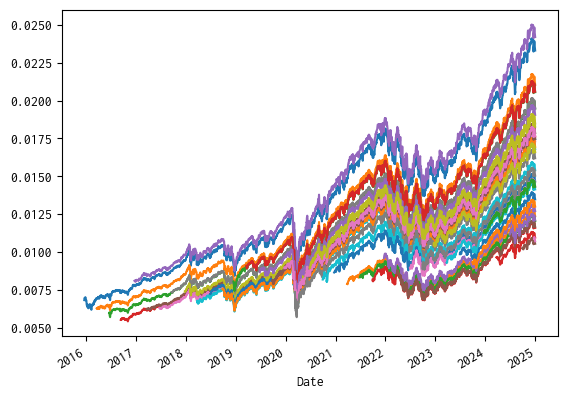

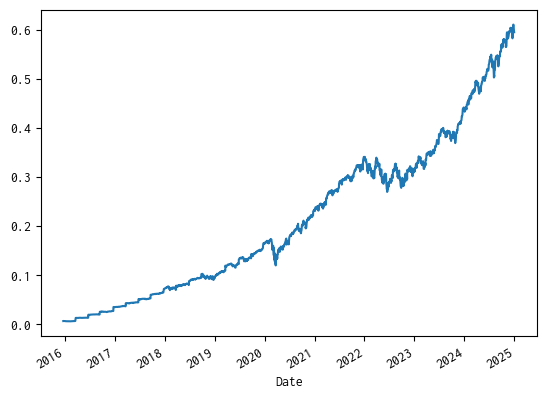

In [22]:
# 分配金再投資のテスト
key = 'VOO'
divs = {}
for dt,divid in relative_div_df[relative_div_df[key]!=0][key].items():
    divs[dt] = close_df[close_df.index>=dt][key]/close_df[key][dt]*divid
for dt in divs.keys():
    divs[dt].plot()
plt.show()
plt.close('all')

# 分配金再投資の合計のテスト
key = 'VOO'
divs = {}
for dt,divid in relative_div_df[relative_div_df[key]!=0][key].items():
    divs[dt] = close_df[close_df.index>=dt][key]/close_df[key][dt]*divid
pd.DataFrame(divs).sum(axis=1).plot()
plt.show()
plt.close('all')

### 分配金再投資系列の作成

<Axes: >

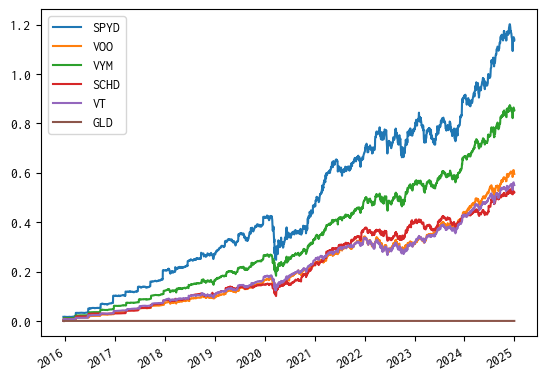

In [8]:
temporal_data = {}
for key in key_list:
    divs = {}
    # 分配金受取時の基準価額を1.0とした相対価額時系列に分配金を乗算する
    for dt,divid in relative_div_df[relative_div_df[key]!=0][key].items():
        divs[dt] = close_df[close_df.index>=dt][key]/close_df[key][dt]*divid
    # 分配金受取時ごとの系列をDataFrame型に変換し全て加算する
    temporal_data[key] = pd.DataFrame(divs).sum(axis=1)
# 分配金運用額のみのデータ
divid_reinvest_df = pd.DataFrame({key:value for key, value in sorted(temporal_data.items(), key=lambda x: min(x[1].index) if x[1].size > 0 else datetime.datetime(2099,1,1))}).fillna(0)
divid_reinvest_df.plot()

<Axes: >

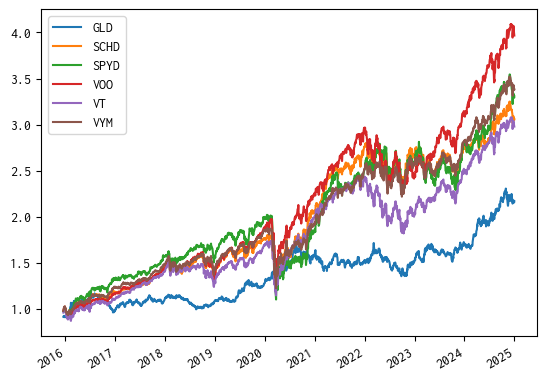

In [9]:
# キャピタルゲイン+分配金
relative_close_and_div_reinvest = relative_close_df + divid_reinvest_df
relative_close_and_div_reinvest.plot()

# 傾向分析

トレンドは同じく右上がりだが，季節性や残差が無相関の系列を探したい

- [ ] 分配金再投資系列を，集計範囲のみに削ってから，元のETF相対時系列に足したトータルリターンのグラフを作成する
- [x] 分配金再投資系列をトレンドと季節制変動に分解する
- [x] 季節性，残差の相関を計算する
- [ ] 年推移相関係数をプロットする
- [ ] リスク最小化の比率を計算する

In [25]:
trimmed = relative_close_and_div_reinvest[np.logical_and(relative_close_and_div_reinvest.index > datetime.datetime(2015,12,31), relative_close_and_div_reinvest.index < datetime.datetime(2023,1,1))]

## 時系列の季節性分離

In [26]:
voo_anal = seasonal_decompose(trimmed['VOO'], period=251)
spyd_anal = seasonal_decompose(trimmed['SPYD'], period=251)
vym_anal = seasonal_decompose(trimmed['VYM'], period=251)
vt_anal = seasonal_decompose(trimmed['VT'], period=251)
gld_anal = seasonal_decompose(trimmed['GLD'], period=251)

## 形状確認:トレンド，季節性，残差の出力

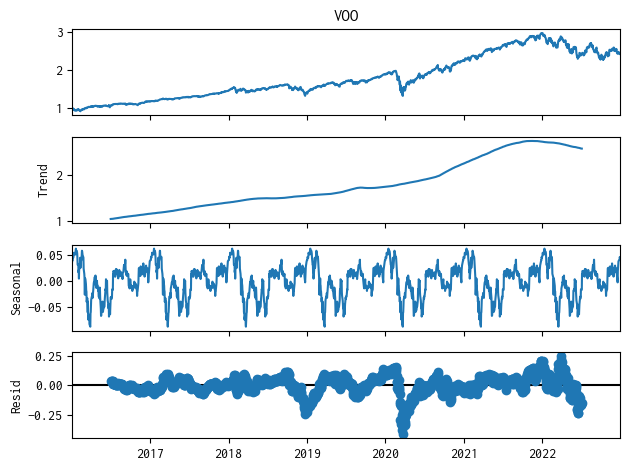

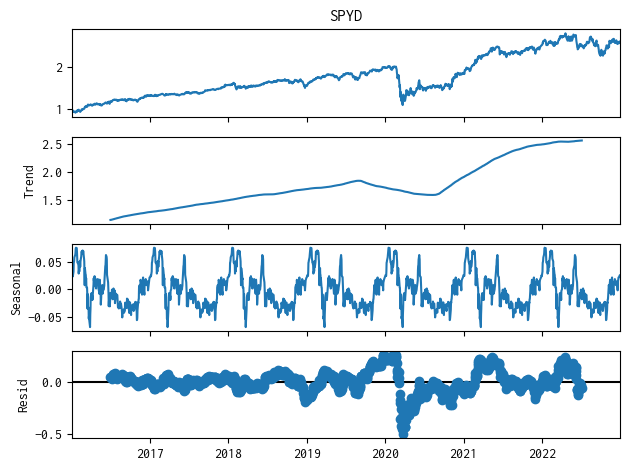

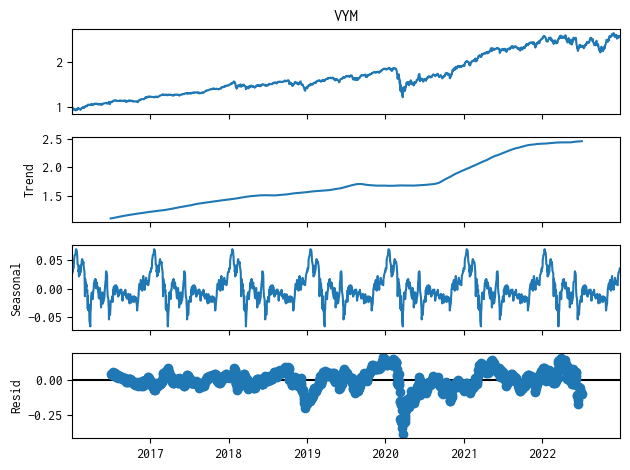

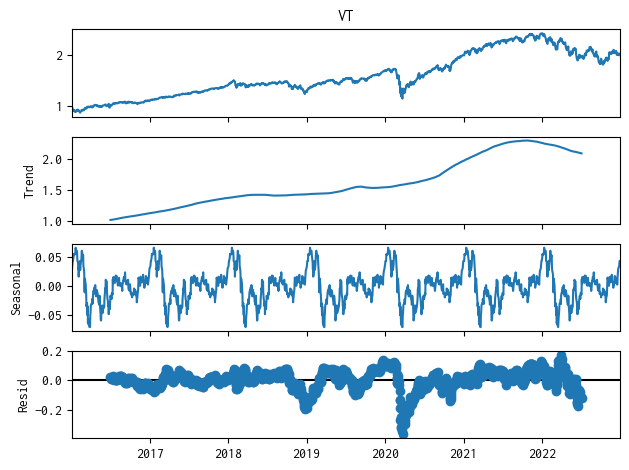

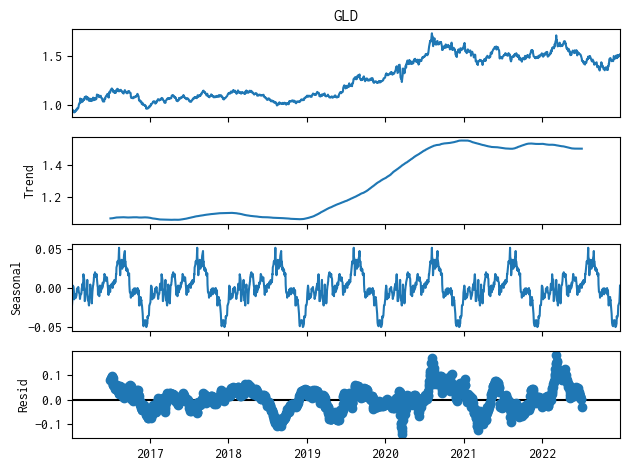

In [27]:
voo_anal.plot()
spyd_anal.plot()
vym_anal.plot()
vt_anal.plot()
gld_anal.plot()
pass

## 時系列そのまま

### ペアプロット

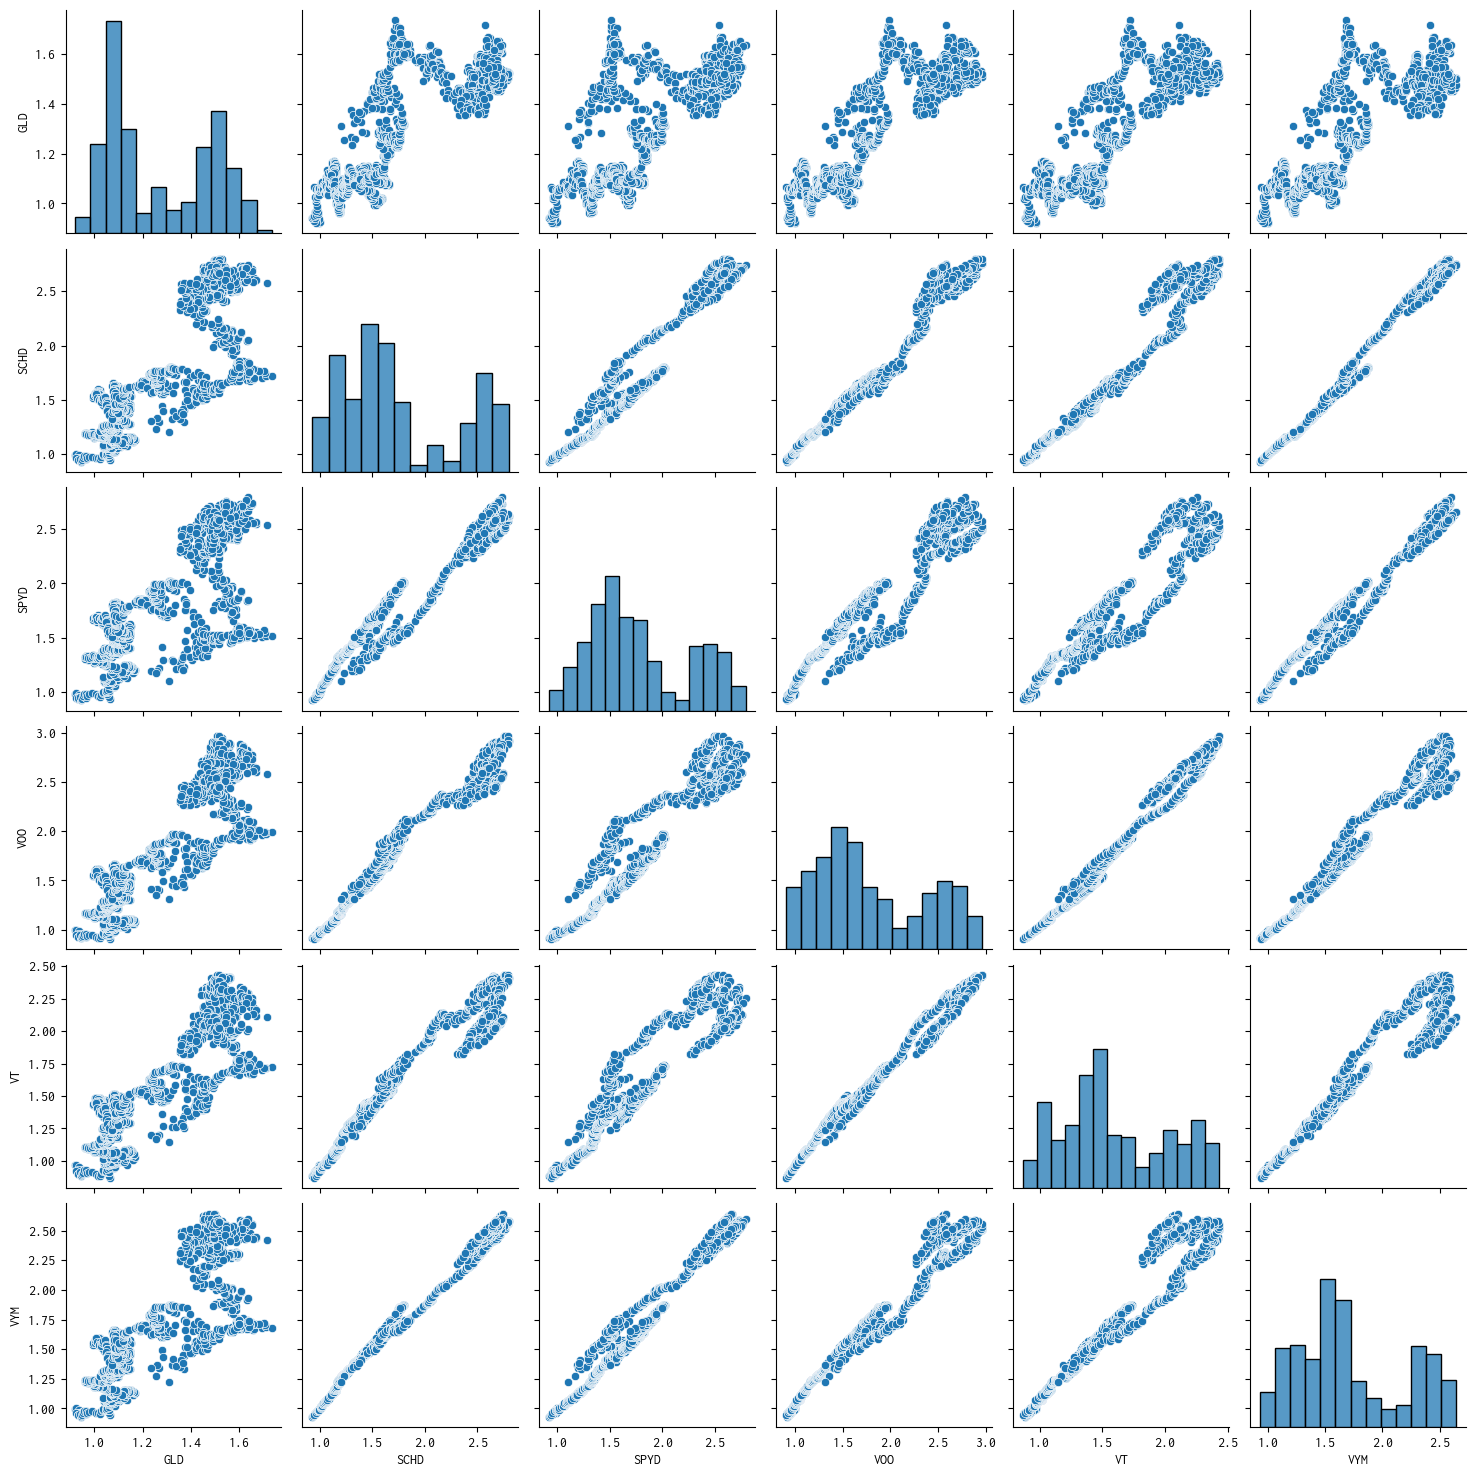

In [28]:
sns.pairplot(trimmed)

### 相関行列

In [29]:
trimmed.corr()

,GLD,SCHD,SPYD,VOO,VT,VYM
GLD,1.000000,0.823543,0.707108,0.866512,0.848397,0.802748
SCHD,0.823543,1.000000,0.969270,0.987354,0.974155,0.993851
SPYD,0.707108,0.969270,1.000000,0.938007,0.926213,0.982958
VOO,0.866512,0.987354,0.938007,1.000000,0.992349,0.978423
VT,0.848397,0.974155,0.926213,0.992349,1.000000,0.963194
VYM,0.802748,0.993851,0.982958,0.978423,0.963194,1.000000


## 季節性成分

### ペアプロット

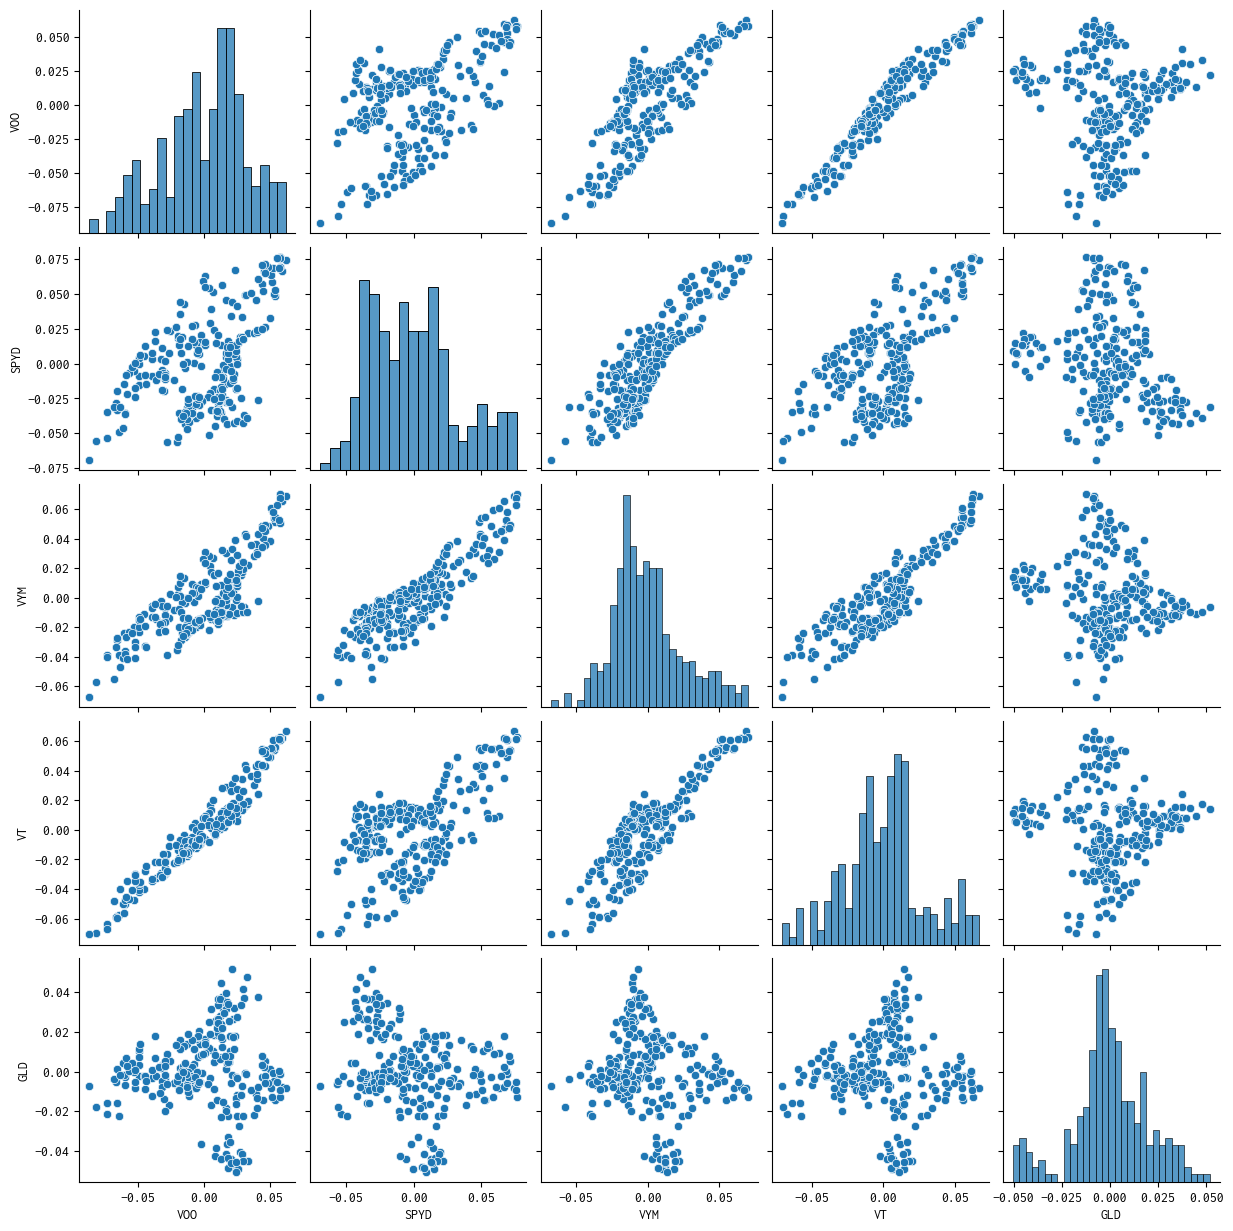

In [30]:
seasonal = pd.DataFrame({'VOO':voo_anal.seasonal, 'SPYD':spyd_anal.seasonal, 'VYM':vym_anal.seasonal, 'VT':vt_anal.seasonal, 'GLD':gld_anal.seasonal})
sns.pairplot(seasonal)

### 相関行列

In [31]:
seasonal.corr()

,VOO,SPYD,VYM,VT,GLD
VOO,1.000000,0.495158,0.809659,0.963412,-0.010825
SPYD,0.495158,1.000000,0.885594,0.634126,-0.233772
VYM,0.809659,0.885594,1.000000,0.877550,-0.162199
VT,0.963412,0.634126,0.877550,1.000000,-0.009562
GLD,-0.010825,-0.233772,-0.162199,-0.009562,1.000000


## 残差

### ペアプロット

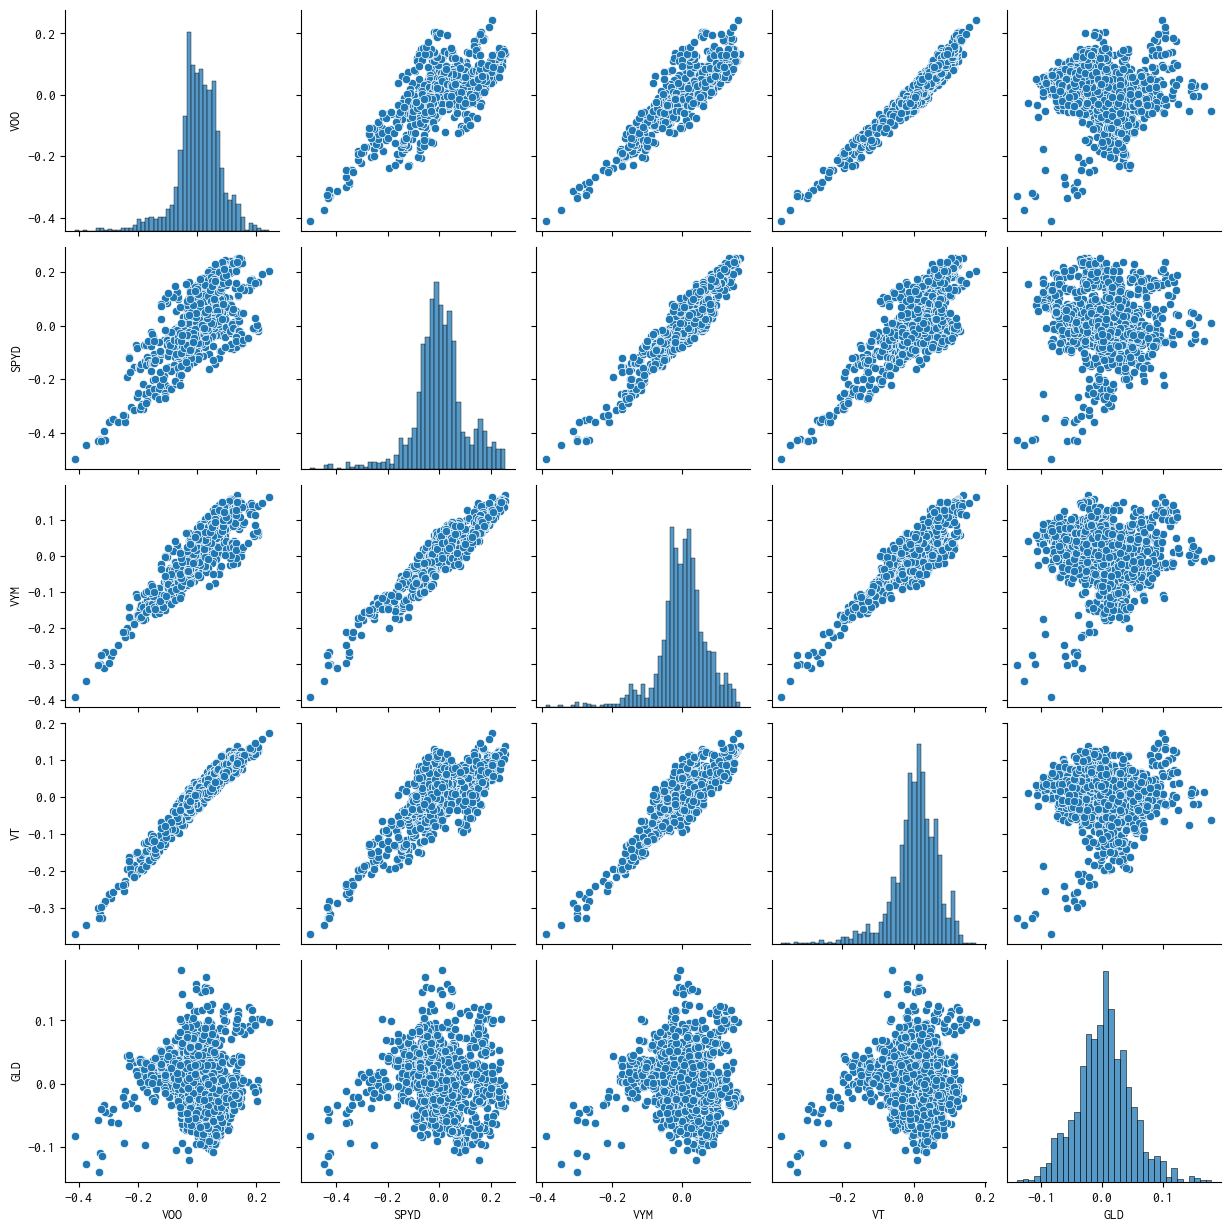

In [32]:
resid = pd.DataFrame({'VOO':voo_anal.resid, 'SPYD':spyd_anal.resid, 'VYM':vym_anal.resid, 'VT':vt_anal.resid, 'GLD':gld_anal.resid})
sns.pairplot(resid)

### 相関行列

In [33]:
resid.corr()

,VOO,SPYD,VYM,VT,GLD
VOO,1.000000,0.699434,0.870402,0.962974,-0.019817
SPYD,0.699434,1.000000,0.937809,0.768280,-0.057666
VYM,0.870402,0.937809,1.000000,0.890775,-0.028937
VT,0.962974,0.768280,0.890775,1.000000,-0.028067
GLD,-0.019817,-0.057666,-0.028937,-0.028067,1.000000


## 季節性+残差 (トレンド成分除去)

### ペアプロット

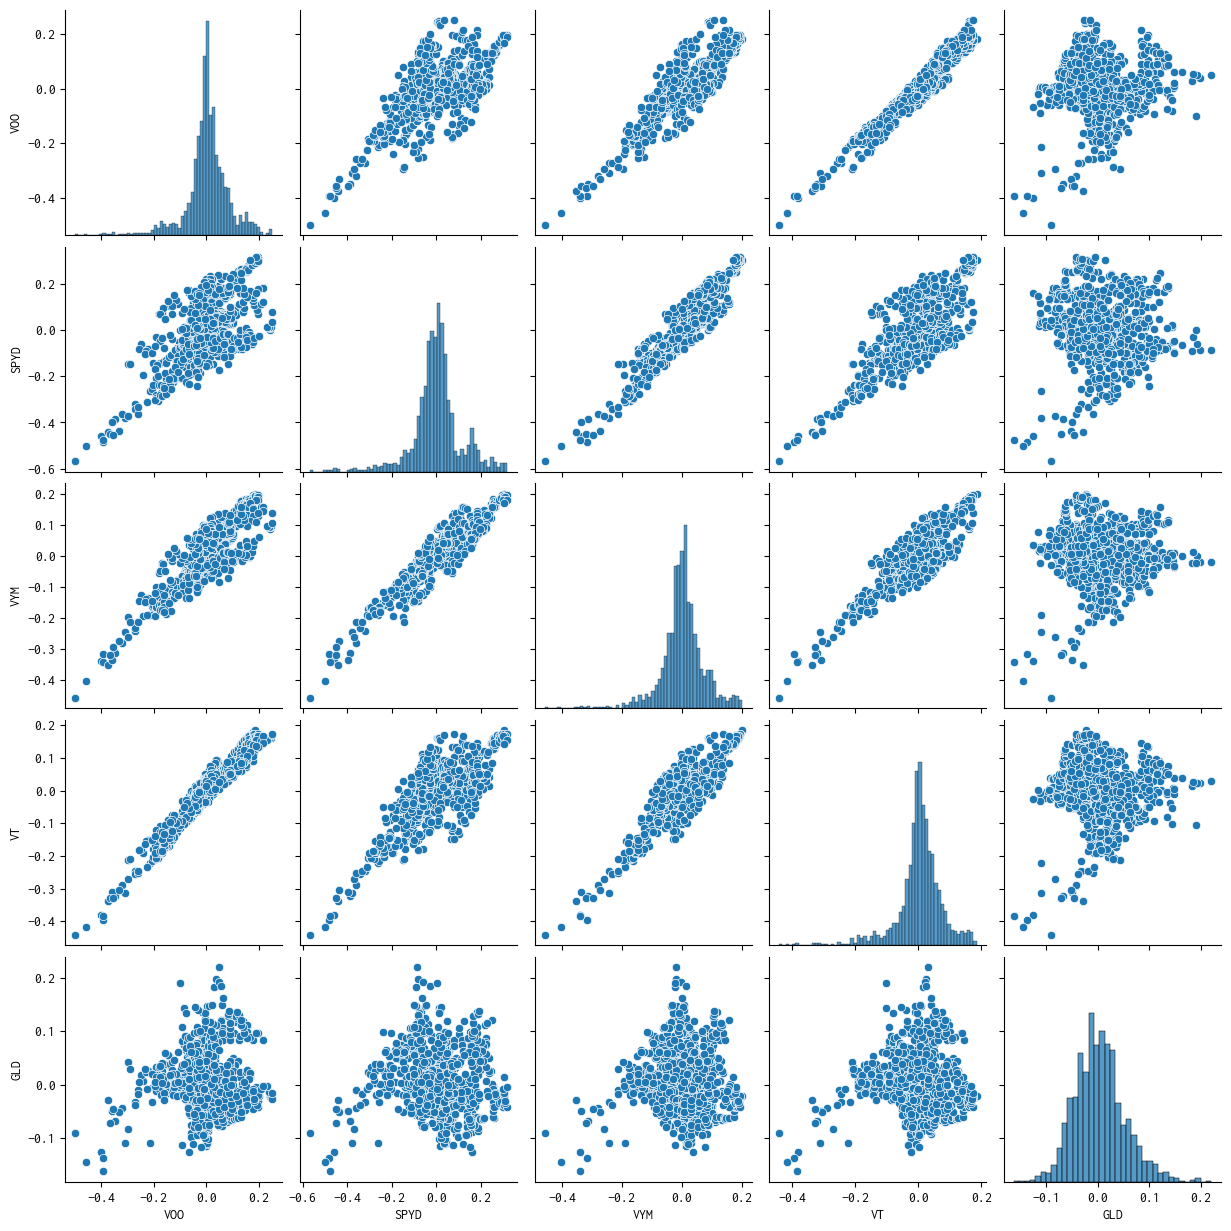

In [34]:
sns.pairplot(seasonal+resid)

### 相関行列

In [35]:
(seasonal+resid).corr()

,VOO,SPYD,VYM,VT,GLD
VOO,1.000000,0.672560,0.861395,0.963011,-0.018173
SPYD,0.672560,1.000000,0.931147,0.749405,-0.078642
VYM,0.861395,0.931147,1.000000,0.888171,-0.047414
VT,0.963011,0.749405,0.888171,1.000000,-0.024934
GLD,-0.018173,-0.078642,-0.047414,-0.024934,1.000000


# レポーティング

## レポート条件の設定

### オルカン1本と、オルカン+他資産のPFの比較

- 投資頻度
    - 月1回 定額積立 1円
    - 年初1回 定額積立 12円
    - 当初1回 120円
- 投資銘柄
    - VT
    - VT, GLD
- リバランス条件
    - なし
    - PFからの乖離ポイント 1pt
    - PFからの乖離ポイント 10pt
- リバランス頻度
    - 年1回
    - 年2回
    - 年4回
- リバランス方法
    - 解約&買付 (リバランス頻度のタイミングで目標PFを目指して利益確定&購入)
    - ノーセル (定額買い付け時に常に目標PFを目指した配分で買い付け)

In [4]:
def buy_fund(target_df, t):
    '''時刻 t の価額を1とした場合の正規化時系列を返却
    '''
    tmp_df = target_df[target_df.index >= t]
    return tmp_df/tmp_df.head(1).values

In [5]:
def get_dividends(close_df, div_df, t):
    return div_df[div_df.index == t].fillna(0)/close_df[close_df.index == t]  # 額面に対する分配金額の率

In [6]:
def rebalance_judge(target_snapshot, portfolio, threshold = 1):
    rate = target_snapshot/target_snapshot.values.sum()  # 資産割合
    diff = (rate-portfolio)*100  # 乖離
    display(diff.abs().max(axis=1))
    if diff.abs().max(axis=1).values[0] > threshold:
        return True
    else:
        return False

## リバランス

### 考え方

- 計算条件:
    - 目標ポートフォリオと自ポートフォリオの乖離を計算し，閾値を越えた場合にリバランスする
    - この関数では超過ウェイトとなった資産を売却し，不足ウェイトの資産を購入する
    - 資産売却時の税率は TAX_RATE とし，2025年現在の日本では 20.315% (申告分離課税)
- 資産が2種類の場合の計算
    - 資産総額をそれぞれ $X_1, X_2$ とする
    - 投資元本をそれぞれ $O_1, O_2$ とする
    - 利益率をそれぞれ $p_1, p_2$ とする、すなわち $X_i = (1+p_i)O_i$ また, $p_1=\frac{X_1}{O_1}-1$である
    - ポートフォリオを $r_1, r_2$ とする

- 税率 $r_t$
- 売却額 $\Delta X_1$
- 税金 tax=$p_1O_1\frac{\Delta X_1}{X_1}r_t$
- 税引き後受取額 $\Delta X_{1-}=\Delta X_1-{\rm tax}$
- 購入額=$\Delta X_{1-}=\Delta X_2$

ここで，$\Delta X_1$を求めたい
$$\Delta X_{1-}=\Delta X_1-{\rm tax}=\Delta X_1(1-r_t)$$
リバランス後の資産額の比率が
$$X_1-\Delta X_1:X_2+\Delta X_{1-}=r_1:r_2$$
であることから，
$$(X_1-\Delta X_1)r_2=(X_2+\Delta X_1-{\rm tax})r_1$$
が成立する
$$r_2X_1-r_2\Delta X_1=r_1X_2+r_1\Delta X_1-r_1p_1O_1\frac{\Delta X_1}{X_1}r_t$$
ここで
$$r_1+r_2=1$$
であることから
$$r_2X_1-r_1X_2=(r_1+r_2)\Delta X_1-r_1\Delta X_1\frac{r_1p_1O_1r_t}{X_1}$$
$$r_2X_1-r_1X_2=\Delta X_1\left(1-\frac{r_1p_1O_1r_t}{X_1}\right)$$
さて、ここで $X_1=(1+p_1)O_1$ に注意して
$$\frac{O_1}{X_1}=\frac{1}{1+p_1}$$
より
$$r_2X_1-r_1X_2=\Delta X_1\left(1-\frac{r_1p_1r_t}{1+p_1}\right)$$
以上から
$$\Delta X_1=\frac{r_2X_1-r_1X_2}{1-\frac{r_1p_1r_t}{1+p_1}}$$

## TODO

- [ ] 3資産以上の場合のリバランス

### 実装

In [7]:
TAX_RATE = 0.20315

def rebalance(assets, principle, portfolio, verbose=False):
    '''リバランスをちゃんとやるための関数
    この関数が呼ばれた時点で，リバランス条件を満たしており，この関数はportfolioにピッタリ合わせることを目的とする
    本当は、売却益の TAX_RATE とするべきだが、現状は売却総額の TAX_RATEになっている

    Parameters
    ----------
    assets : pandas.DataFrame
        資産時系列のDataFrameのうち，リバランスしたい時刻インデックスのスライス
        資産が N 個の時，assets.shape == (1, N)
    principle : pandas.DataFrame
        元本
    portfolio : pandas.Series
        columns が資産時系列の名前, value がその資産のウェイトであり正規化済のもの
    '''

    # pd.Seriesに変換
    assets = assets.iloc[0]
    principle = principle.iloc[0]

    # 利益率計算
    benefit = assets-principle
    bene_rate = (assets/principle-1)

    # 逆比の差
    r2x1_r1x2 = portfolio.iloc[1]*assets.iloc[0] - portfolio.iloc[0]*assets.iloc[1]

    if r2x1_r1x2>0:
        # 1の資産を売って2の資産を買う
        if bene_rate.iloc[0]>0:
            # 利益が出てたら税金を考慮して売却額を決定
            dx1 = r2x1_r1x2/(1-portfolio.iloc[0]*bene_rate.iloc[0]*TAX_RATE)  # 売却額
            tax = bene_rate.iloc[0]*principle.iloc[0]*dx1*TAX_RATE/assets.iloc[0]  # 税額
            dx2 = dx1 - tax  # 税引き後受け渡し額=購入額

            sell_buy = pd.Series([-dx1,dx2],name=t)
            sell_buy.index=assets.index
        else:
            # 利益が出てない時は税金を無視して売却額を決定
            sell_buy = pd.Series([-r2x1_r1x2,r2x1_r1x2],name=t)
            sell_buy.index=assets.index
    else:
        # 2の資産を売って1の資産を買う

    return sell_buy, tax

Date
2016-03-01    1.065221
dtype: float64

/tmp/ipykernel_143342/2963925255.py:19: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dx1 = np.cross(assets.values, portfolio.values)
/tmp/ipykernel_143342/2963925255.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r1tx = (portfolio * TAX_RATE)[0]
/tmp/ipykernel_143342/2963925255.py:34: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dx2 = np.cross(sell.values, np.array([0,1-TAX_RATE]))


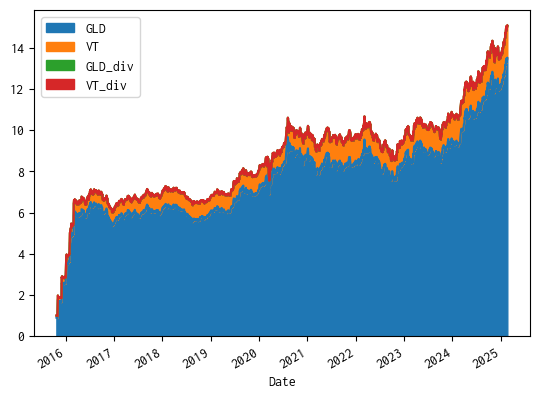

total return is  15.093179488476277


/tmp/ipykernel_143342/1137852328.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('total return is ', total.sum(axis=1)[-1])


In [8]:
# デバッグ用データロード

condition = [
    {'GLD': 9.0, 'VT': 1.0 }  # ポートフォリオ {'ticker': rate, }
    , [1,2,3,4,5,6,7,8,9,10,11,12]  # 投資頻度 (月のリスト)
    , 1  # 投資金額
    , 1  # リバランス条件 (最大の乖離ポイントをパーセンタイルで指定)
    , [3,]  # リバランス頻度 (月のリスト)
    , True  # リバランス方法 (True: 解約・買い付け, False: ノーセルリバランスを毎月)
    , 'VT&GLD'  # name
    ]

portfolio = pd.Series(condition[0])
target_close = close_df[portfolio.keys()]
dividends = {}
for ticker in portfolio.keys():
    dividends[ticker] = dividends_df[dividends_df[ticker]>0][ticker]
target_div = pd.DataFrame(dividends)

timestamps = target_close.index
div_timestamps = target_div.index
buy_monthes = condition[1]
portfolio *= condition[2]/portfolio.sum()
threshold = condition[3]
rebalance_monthes = condition[4]
rebalance_method = condition[5]

prev = -1

result = target_close * 0  # 現在資産
buy_history = target_close * 0  # 投資記録
receive_dividends = target_close * 0  # 受け取った分配金

for t in timestamps:
    if t.month != prev:
        # reset behavior
        bought = False
        rebalanced = False
        prev = t.month
    if t.month in buy_monthes:
        # rebalance_method = False の場合，買い付け額が変更
        if not bought:
            ### 原価を累積する時系列を用意する
            #display('buy history', (buy_fund(target_close, t)*portfolio)[target_close.index==t])
            buy_history.loc[t] += portfolio
            result = result.add(buy_fund(target_close, t)*portfolio, fill_value=0)  # 現在資産に買った投信を加算
            bought = True
    if t.month in rebalance_monthes:
        if not rebalanced:
            if rebalance_judge(result[result.index==t], portfolio, threshold):
                principle = buy_history.cumsum()
                tmp = rebalance(result[result.index==t], principle[principle.index==t], portfolio)  # リバランスには原価が必要
                # rebalance
                break
            else:
                display('not rebalance')
            rebalanced = True
    if t in div_timestamps:
        # 分配金
        receive_dividends = receive_dividends.add((result*get_dividends(target_close, target_div, t)).dropna(), fill_value=0)

div_df = receive_dividends.cumsum()
div_df.columns = [col + '_div' for col in div_df.columns]
total = pd.concat([result, div_df], axis=1)

#display(buy_history)

total.plot.area()
plt.show()
plt.close('all')

print('total return is ', total.sum(axis=1)[-1])


In [56]:
assets=result[result.index==t].iloc[0]  # seriesに変換
assets

GLD    5.872500
VT     0.576175
Name: 2016-03-01 00:00:00, dtype: float64

In [59]:
tmp=buy_history.cumsum()
principle=tmp[tmp.index==t].iloc[0]  # seriesに変換
principle

GLD    5.4
VT     0.6
Name: 2016-03-01 00:00:00, dtype: float64

In [61]:
benefit=(assets-principle)  # もともとseries
benefit

GLD    0.472500
VT    -0.023825
Name: 2016-03-01 00:00:00, dtype: float64

In [63]:
bene_rate=(assets/principle-1)  # もともとseries
bene_rate

GLD    0.087500
VT    -0.039709
Name: 2016-03-01 00:00:00, dtype: float64

In [68]:
r2x1_r1x2=portfolio.iloc[1]*assets.iloc[0] - portfolio.iloc[0]*assets.iloc[1]  # 逆比の差
r2x1_r1x2

np.float64(0.06869266261181917)

In [88]:
if r2x1_r1x2>0:
    # 1の資産を売って2の資産を買う
    if bene_rate.iloc[0]>0:
        #if False:
        # 利益が出てたら税金を考慮して売却額を決定
        dx1 = r2x1_r1x2/(1-portfolio.iloc[0]*bene_rate.iloc[0]*TAX_RATE)  # 売却額
        tax = bene_rate.iloc[0]*principle.iloc[0]*dx1*TAX_RATE/assets.iloc[0]  # 税額
        dx2 = dx1-tax  # 税引き後受け渡し額=購入額
        print('dx1',dx1)
        print('tax',tax)
        print('dx2',dx2)
        sell_buy = pd.Series([-dx1,dx2],name=t)
        sell_buy.index=assets.index
        print('sell buy vector',sell_buy)
        after=assets+sell_buy
        print('after', after)
        print('after rate', after/after.sum())
    else:
        # 利益が出てない時は税金を無視して売却額を決定
        sell_buy = pd.Series([-r2x1_r1x2,r2x1_r1x2],name=t)
        sell_buy.index=assets.index
        print('sell buy vector', sell_buy)
        after=assets+sell_buy
        print('after', after)
        print('after rate', after/after.sum())

sell buy vector GLD   -0.068693
VT     0.068693
Name: 2016-03-01 00:00:00, dtype: float64
after GLD    5.803808
VT     0.644868
Name: 2016-03-01 00:00:00, dtype: float64
after rate GLD    0.9
VT     0.1
Name: 2016-03-01 00:00:00, dtype: float64


In [92]:
buy_history.loc[t] += sell_buy
buy_history.loc[:t]

,GLD,VT
Date,,
2015-10-22,0.9,0.1
2015-10-23,0.0,0.0
2015-10-26,0.0,0.0
2015-10-27,0.0,0.0
2015-10-28,0.0,0.0
...,...,...
2025-02-13,0.0,0.0
2025-02-14,0.0,0.0
2025-02-18,0.0,0.0


## シミュレーション条件

In [7]:
# 対象の時系列の終値と分配金の時系列を取得する

conditions = [
    [ {'VT': 9.0, 'GLD': 1.0 }  # ポートフォリオ {'ticker': rate, }
    , [1,2,3,4,5,6,7,8,9,10,11,12]  # 投資頻度 (月のリスト)
    , 1  # 投資金額
    , 1  # リバランス条件 (最大の乖離ポイントをパーセンタイルで指定)
    , [3,]  # リバランス頻度 (月のリスト)
    , True  # リバランス方法 (True: 解約・買い付け, False: ノーセルリバランスを毎月)
    , 'VT&GLD'  # name
    ],
    [ {'VT': 1.0 }  # ポートフォリオ {'ticker': rate, }
    , [1,2,3,4,5,6,7,8,9,10,11,12]  # 投資頻度 (月のリスト)
    , 1  # 投資金額
    , 1  # リバランス条件 (最大の乖離ポイントをパーセンタイルで指定)
    , [3,]  # リバランス頻度 (月のリスト)
    , True  # リバランス方法 (True: 解約・買い付け, False: ノーセルリバランスを毎月)
    , 'VT'  # name
    ],
]

#close_df      # 終値時系列
#dividends_df  # 分配金時系列

# 投資頻度の実装
## 投資タイミングの日を先頭とした時系列を切り出し、その先頭の値で相対化した正規化時系列を生成し、投資金額で乗じたものを、独立した時系列として生成する
## その時系列を積立期間の最後まで生成し続けリストとし、そのリストの和を取る



## シミュレーション

Date
2016-03-01    1.176631
dtype: float64

,VT,GLD
Date,,
2016-03-01,-0.011766,0.011766


Date
2017-03-01    0.738709
dtype: float64

'not rebalance'

Date
2018-03-01    1.099264
dtype: float64

,VT,GLD
Date,,
2018-03-01,0.010993,-0.010993


Date
2019-03-01    1.006853
dtype: float64

,VT,GLD
Date,,
2019-03-01,0.010069,-0.010069


Date
2020-03-02    0.294863
dtype: float64

'not rebalance'

Date
2021-03-01    1.415602
dtype: float64

,VT,GLD
Date,,
2021-03-01,0.014156,-0.014156


Date
2022-03-01    0.506067
dtype: float64

'not rebalance'

Date
2023-03-01    0.4382
dtype: float64

'not rebalance'

Date
2024-03-01    1.114206
dtype: float64

,VT,GLD
Date,,
2024-03-01,0.011142,-0.011142


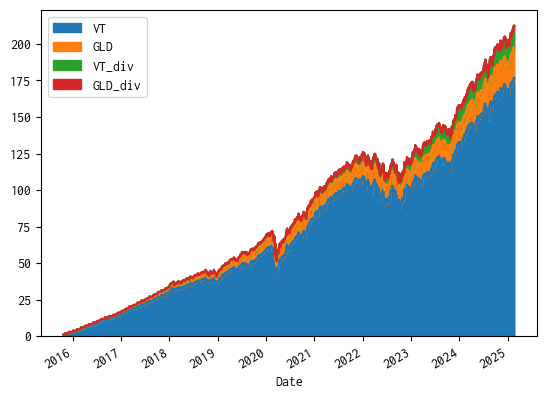

total return is  212.27140718707602


/tmp/ipykernel_1117181/802799325.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('total return is ', total.sum(axis=1)[-1])


Date
2016-03-01    0.0
dtype: float64

'not rebalance'

Date
2017-03-01    0.0
dtype: float64

'not rebalance'

Date
2018-03-01    0.0
dtype: float64

'not rebalance'

Date
2019-03-01    0.0
dtype: float64

'not rebalance'

Date
2020-03-02    0.0
dtype: float64

'not rebalance'

Date
2021-03-01    0.0
dtype: float64

'not rebalance'

Date
2022-03-01    0.0
dtype: float64

'not rebalance'

Date
2023-03-01    0.0
dtype: float64

'not rebalance'

Date
2024-03-01    0.0
dtype: float64

'not rebalance'

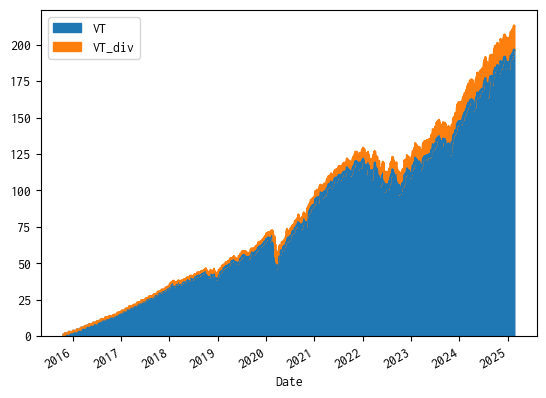

total return is  212.72141938831697


/tmp/ipykernel_1117181/802799325.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('total return is ', total.sum(axis=1)[-1])


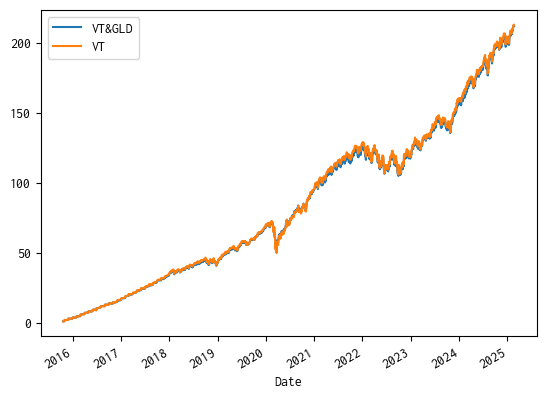

In [16]:
total_data = {}

for condition in conditions:

    # make generate functions
    portfolio = pd.Series(condition[0])
    target_close = close_df[portfolio.keys()]
    dividends = {}
    for ticker in portfolio.keys():
        dividends[ticker] = dividends_df[dividends_df[ticker]>0][ticker]
    target_div = pd.DataFrame(dividends)

    timestamps = target_close.index
    div_timestamps = target_div.index
    buy_monthes = condition[1]
    portfolio *= condition[2]/portfolio.sum()
    threshold = condition[3]
    rebalance_monthes = condition[4]
    rebalance_method = condition[5]
    prev = 9

    result = target_close * 0  # 現在資産
    receive_dividends = target_close * 0  # 受け取った分配金

    for t in timestamps:
        if t.month != prev:
            # reset behavior
            bought = False
            rebalanced = False
            prev = t.month
        if t.month in buy_monthes:
            # rebalance_method = False の場合，買い付け額が変更
            if not bought:
                result = result.add(buy_fund(target_close, t)*portfolio, fill_value=0)  # 現在資産に買った投信を加算
                bought = True
        if t.month in rebalance_monthes:
            if not rebalanced:
                if rebalance_judge(result[result.index==t], portfolio, threshold):
                    tmp = rebalance(result[result.index==t], portfolio)
                    # rebalance
                else:
                    display('not rebalance')
                rebalanced = True
        if t in div_timestamps:
            # 分配金
            receive_dividends = receive_dividends.add((result*get_dividends(target_close, target_div, t)).dropna(), fill_value=0)

    div_df = receive_dividends.cumsum()
    div_df.columns = [col + '_div' for col in div_df.columns]
    total = pd.concat([result, div_df], axis=1)

    total.plot.area()
    plt.show()
    plt.close('all')

    print('total return is ', total.sum(axis=1)[-1])

    total_data[condition[6]] = total.sum(axis=1)
pd.DataFrame(total_data).plot()
plt.show()

In [10]:

#display(result[result.index==timestamps[1000]], portfolio, 1)
#rebalance_judge(result[result.index==timestamps[1000]], portfolio, 1)
diff = tmp/tmp.values.sum()-portfolio
diff.max(axis=1).values[0]

NameError: name 'tmp' is not defined

In [11]:
result

,VT
Date,
2015-10-22,1.000000
2015-10-23,1.009270
2015-10-26,1.006236
2015-10-27,1.000000
2015-10-28,1.008428
...,...
2025-02-13,195.733865
2025-02-14,195.940130
2025-02-18,196.701746
